In [1]:
%matplotlib inline

In [528]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize
from scipy import integrate,interpolate

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import gsw

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 4])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [596]:
file = '../data/goship/selected/P01_20070724_00011_00001_ct1.csv'
data = pd.read_csv(file,header=17,skipfooter=1,engine='python')
# data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 8','ML/L'])
data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 9','Unnamed: 10','MG/M^3','UMOL/KG'])
data.rename(columns={'ITS-90':'tmp','PSS-78':'sal','DBAR':'prs'},inplace=True)

In [597]:
lon0 = 146.3
lat0 = 41.9
data['sal'] = gsw.SA_from_SP(data.sal,data.prs,lon0,lat0)
data['tmp'] = gsw.CT_from_t(data.sal,data.tmp,data.prs)
data['rho'] = gsw.rho(data.sal,data.tmp,3000)
data['z'] = gsw.z_from_p(data.prs, lat0)

In [598]:
bins = np.arange(0,6000,2)
data = data.groupby(pd.cut(data.prs,bins)).mean()

In [599]:
ds = pd.DataFrame()
ds['N2'],ds['pmid']= gsw.Nsquared(data.sal,data.tmp,data.prs,lat=40)
ds['z'] = gsw.z_from_p(ds.pmid, lat0)

In [600]:
ds = ds.rolling(window=10,center=True,win_type='hamming').mean()
N0 = np.nanmean( np.sqrt(ds.N2) )
ds['N/N0'] = np.sqrt(ds.N2)/N0

### GO-SHIP full-depth T,S,$\rho$ profiles

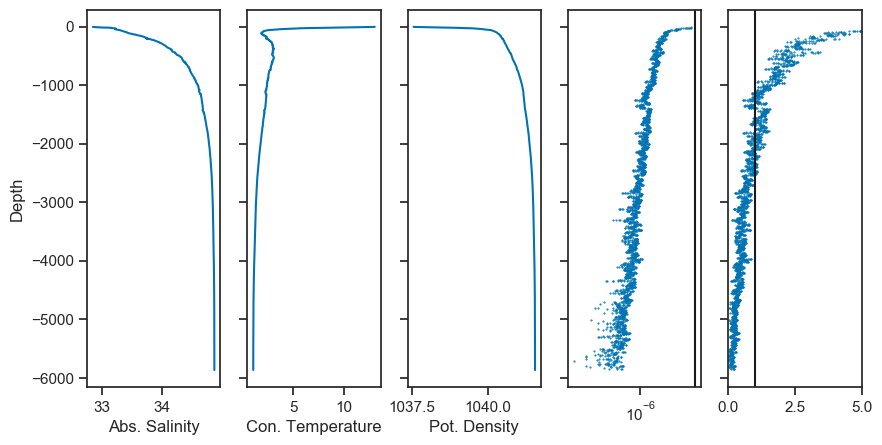

In [601]:
f,ax = plt.subplots(1,5,sharey=True, figsize=(10,5))
ax[0].plot(data.sal,data.z,'-')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Abs. Salinity')
ax[1].plot(data.tmp,data.z,'-')
ax[1].set_xlabel('Con. Temperature')
ax[2].plot(data.rho,data.z,'-')
ax[2].set_xlabel('Pot. Density')

ax[3].plot(ds.N2,ds.z,'.', markersize=1)
ax[3].axvline(N0,color='k')
ax[3].set_xscale('log')
# ax[3].set_xlim(5e-4,1e-2);

ax[4].plot(ds['N/N0'],ds.z,'.', markersize=1)
ax[4].axvline(N0/N0,color='k')
# ax[4].set_xscale('log')
ax[4].set_xlim(0,5);

# plt.ylim(-1000,0)

### WKB-streched depth z':
$$
z'(z) = \int_0^z \frac{N(z)}{<N>} dz
$$

In [569]:
ds = ds.sort_values('z',ascending=False)
ds = ds.dropna()
zmid = 0.5*( ds.z.values[0:-1] + ds.z.values[1:])
zprime = integrate.cumtrapz(ds['N/N0'],ds['z'])

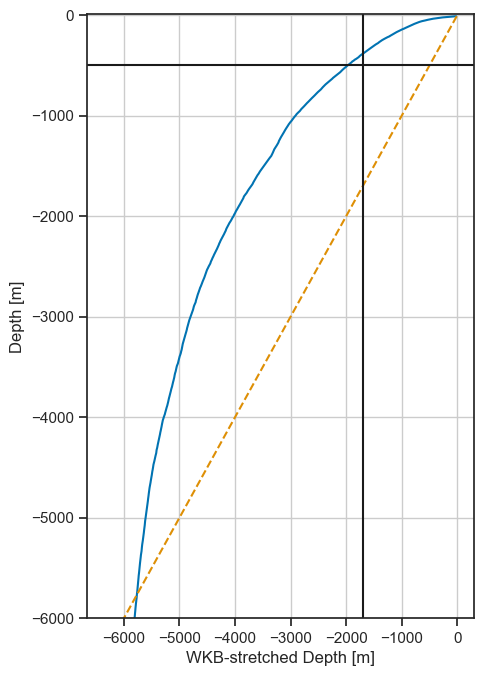

In [570]:
plt.figure(figsize=(5,8))
plt.plot(zprime,zmid)
plt.plot(zmid,zmid,linestyle='dashed')
plt.axhline(-500, color='k')
plt.axvline(-1700, color='k')
# plt.annotate('max. z observation',(-6000,-400))
plt.ylabel('Depth [m]')
plt.xlabel("WKB-stretched Depth [m]")
plt.grid()
plt.ylim(-6000,10);

In [571]:
fraction_resolved = -100*1700/ds.z.min()
print(f'Fraction of the water column resolved: {fraction_resolved:2.2f}%')

Fraction of the water column resolved: 26.77%


### Vertical IW modes for N=const

Equation for vertical structure W from ansatz in wave equation:
$$
\frac{d^2W}{dz^2} + k^2 \left( \frac{N^2}{\omega^2} -1 \right)W = 0
$$
with
$$
W = 0,~ z=-D
$$
and
$$
\omega^2\frac{dW}{dz} - gk^2W = 0,~ z=0
$$

In [572]:
D = -ds.z.min()
W = np.zeros((len(zprime),4))
for j in [1,2,3,4]:
    W[:,j-1] = (-1)**j*np.cos(j*np.pi*zprime/D)

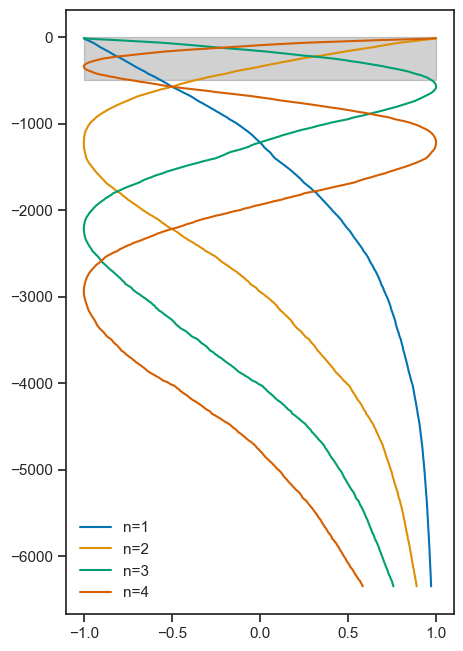

In [573]:
plt.figure(figsize=(5,8))
plt.plot(W,zmid)
plt.legend(labels=['n=1','n=2','n=3','n=4']);
plt.fill_between([-1,1],y1=-500,y2=0,alpha=0.2, color='k');

## Questions:
- Will I spill energy from higher modes into mode 2,3,4 if I only try to fit u'p' to those? 
- How much do I lose by missing mode 1? How can I quantify that?